In [ ]:
import tensorflow as tf
print(tf.__version__)
import cv2
import os
import glob
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import pandas
import csv
import scipy.io as sio
import random
import wave
import gzip
import scipy.io

2.12.0


# Data

## Import dataset from the link

In [ ]:
%%capture

!wget https://www.bbci.de/competition/download/competition_iii/tuebingen/Competition_train.mat.gz
!wget https://www.bbci.de/competition/download/competition_iii/tuebingen/Competition_test.mat.gz

!wget https://www.bbci.de/competition/download/competition_iii/albany/BCI_Comp_III_Wads_2004.zip

In [ ]:
!unzip /content/BCI_Comp_III_Wads_2004.zip

## Decompress the data

## Dataset

In [ ]:
# Specify the path to the compressed Matlab file
compressed_train_path = '/content/Competition_train.mat.gz'
compressed_test_path = '/content/Competition_test.mat.gz'
# Specify the path where you want to save the decompressed file
decompressed_train_path = '/content/Competition_train.mat'
decompressed_test_path = '/content/Competition_test.mat'

# Decompress the train file
with gzip.open(compressed_train_path, 'rb') as compressed_file:
    with open(decompressed_train_path, 'wb') as decompressed_file:
        decompressed_file.write(compressed_file.read())

train_data = scipy.io.loadmat(decompressed_train_path)

# Decompress the test file
with gzip.open(compressed_test_path, 'rb') as compressed_file:
    with open(decompressed_test_path, 'wb') as decompressed_file:
        decompressed_file.write(compressed_file.read())

test_data = scipy.io.loadmat(decompressed_test_path)

## Convert the data to Tensors

## Dataset 1

In [ ]:
# Shuffle the indices
num_samples = len(train_data['X'])
indices = np.arange(num_samples)
np.random.shuffle(indices)

# Split the shuffled indices into training and validation sets
split_index = 254  # or any other desired split point
train_indices = indices[:split_index]
val_indices = indices[split_index:]

# Split the data using the shuffled indices
X_train = train_data['X'][train_indices]
Y_train = train_data['Y'][train_indices]

X_val = train_data['X'][val_indices]
Y_val = train_data['Y'][val_indices]

# Test data remains unchanged
X_test = test_data['X']
# Create TensorFlow datasets
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
Y_train_dataset = tf.data.Dataset.from_tensor_slices(Y_train)


In [ ]:
X_train.shape

(254, 64, 3000)

### Example of one sample

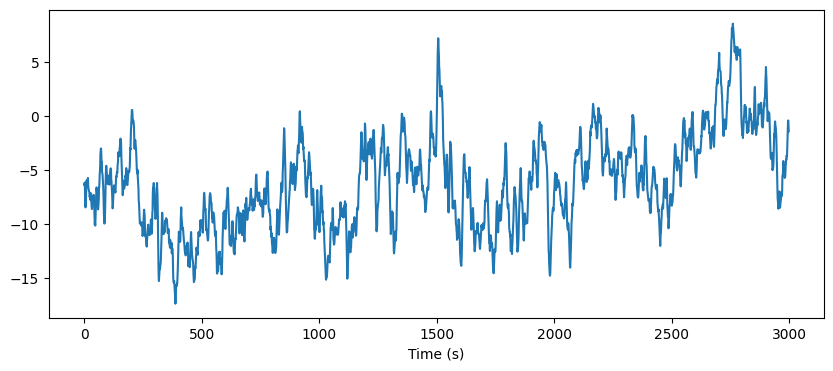

In [ ]:
# 'X' contains the ECoG data for one trial and one electrode channel
ecog_data = X_train[0, 1, :]  # Extract data for one trial and one channel

# Create a time axis (assuming a 1000Hz sampling rate)
time_axis = range(len(ecog_data))

# Plot the ECoG data
plt.figure(figsize=(10, 4))
plt.plot(time_axis, ecog_data)
plt.xlabel('Time (s)')

plt.show()

# GPU config

In [ ]:
! nvidia-smi

Mon Sep  4 13:14:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    32W /  70W |   1411MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Training

## Basic DNN

In [ ]:
from sklearn.preprocessing import OneHotEncoder
#one-hot-encoding of labels (-1,1,1,...,1) --> ([1,0] , [0,1], [0, 1] ,...)
num_classes = 2

# Create the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the original array
encoded_Y_train = encoder.fit_transform(Y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
import keras
import matplotlib.pyplot as plt
import time
import numpy as np
from tqdm import tqdm
from keras.layers import Conv1D , MaxPooling1D, BatchNormalization, Activation , Lambda , Dense , Flatten




"""
=====================================================================================================
                                      Model Architecture
=====================================================================================================
"""

E = X_train.shape[1] # Number of EEG channels
K = 2 # Temporal lengh of the signal
filter_size = (E*K)
num_filters = int(X_train.shape[2]/K)

model_basic = keras.models.Sequential()

# -----------First Convolutional Layer-----------
model_basic.add(Conv1D(filters = 12,
                 kernel_size=filter_size,
                 strides=1,
                 padding="same"))
model_basic.add(MaxPooling1D(pool_size=2))  # Add MaxPooling layer
model_basic.add(BatchNormalization())  # Add BatchNormalization layer
model_basic.add(Activation('relu'))  # Add ReLU activation

# -----------Second Convolutional Layer-----------
model_basic.add(Conv1D(filters = (num_filters/2),
                 kernel_size=filter_size,
                 strides=1,
                 padding="same"))
model_basic.add(MaxPooling1D(pool_size=2))  # Add MaxPooling layer
model_basic.add(BatchNormalization())  # Add BatchNormalization layer
model_basic.add(Activation('relu'))  # Add ReLU activation

# -----------Flatten Layer-----------

# -----------Fully Connected Layer for Multiclass Classification-----------
model_basic.add(Flatten())  # Flatten the output from previous layers
model_basic.add(Dense(16, activation='linear'))  # Add a fully connected layer with 64 units and linear activation
model_basic.add(Dense(num_classes, activation='softmax'))  # Add the output layer with 'num_classes' units and linear activation

# Compile the model
model_basic.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

"""
=====================================================================================================
                                  Training Stage
=====================================================================================================
"""

# Training loop
num_epochs = 20

# Start a timer
start_time = time.time()

# Initialize empty lists to store metrics
history = {'loss': [], 'accuracy': [], 'training_time': []}

with tqdm(total=num_epochs, unit='epoch', position=0, leave=True) as pbar:
    for epoch in range(num_epochs):
        # Your training code here

        model_basic.fit(
            x=X_train,
            y=encoded_Y_train,
            batch_size=1,
            epochs=1,
            shuffle=True,
            verbose=0)  # Set verbose to 0 to suppress output

        # Calculate and append loss and accuracy for the current epoch
        loss, accuracy = model_basic.evaluate(X_train, encoded_Y_train, verbose=0)
        history['loss'].append(loss)
        history['accuracy'].append(accuracy)

        # Update the tqdm progress bar
        pbar.set_description(f'Epoch {epoch + 1}/{num_epochs}')
        pbar.set_postfix(loss=loss, accuracy=accuracy)
        pbar.update(1)

# Stop the timer
end_time = time.time()

# Calculate the total training time
training_time = end_time - start_time
history['training_time'] = training_time

Epoch 20/20: 100%|██████████| 20/20 [01:01<00:00,  3.09s/epoch, accuracy=1, loss=0.00147]


In [ ]:
model_basic.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_30 (Conv1D)          (1, 64, 8)                15360008  
                                                                 
 max_pooling1d_30 (MaxPoolin  (1, 32, 8)               0         
 g1D)                                                            
                                                                 
 batch_normalization_30 (Bat  (1, 32, 8)               32        
 chNormalization)                                                
                                                                 
 activation_30 (Activation)  (1, 32, 8)                0         
                                                                 
 conv1d_31 (Conv1D)          (1, 32, 150)              768150    
                                                                 
 max_pooling1d_31 (MaxPoolin  (1, 16, 150)           

# Validation

## Run Evaluation

In [ ]:
# Create the OneHotEncoder
encoder = OneHotEncoder(sparse=False)

# Fit and transform the original array
encoded_Y_val = encoder.fit_transform(Y_val)

predictions = []

for input_data in X_val:
    input_data = input_data.reshape(1,input_data.shape[0],input_data.shape[1])  # Reshape the input data
    network_output = model_basic.predict(input_data, verbose=0) # This line predicts with the model
    max_index = np.argmax(network_output[0])  # Find the index of the maximum value
    predictions.append([max_index])

# Convert decision_list to the desired format


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Check Testing Accuracy

In [ ]:
true_labels_max = [np.argmax(i) for i in encoded_Y_val] # Get the maximum index for each onehotted label of the subject( the index indicates the class)

In [ ]:
accurate = 0
for test_sample in range(len(predictions)):
   if true_labels_max[test_sample] == predictions[test_sample]:

      accurate += 1

print("Accuracy: " ,accurate/len(predictions))
# Show training time
print(f"Total Training Time: {history['training_time']:.2f} seconds")

Accuracy:  0.7916666666666666
Total Training Time: 61.82 seconds


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for each class
precision = precision_score(true_labels_max, predictions, average=None)
recall = recall_score(true_labels_max, predictions, average=None)
f1 = f1_score(true_labels_max, predictions, average=None)

class_labels = ['small finger movement', 'tongue movement']
# Print class-wise metrics

for class_idx, class_name in enumerate(class_labels):
    print(f"Class: {class_name}\n")
    print(f"Precision: {precision[class_idx]}")
    print(f"Recall: {recall[class_idx]}")
    print(f"F1-Score: {f1[class_idx]}")
    print('---------------------------------------')

Class: small finger movement

Precision: 0.7692307692307693
Recall: 0.8333333333333334
F1-Score: 0.8
---------------------------------------
Class: tongue movement

Precision: 0.8181818181818182
Recall: 0.75
F1-Score: 0.7826086956521738
---------------------------------------


## Confusion Matrix

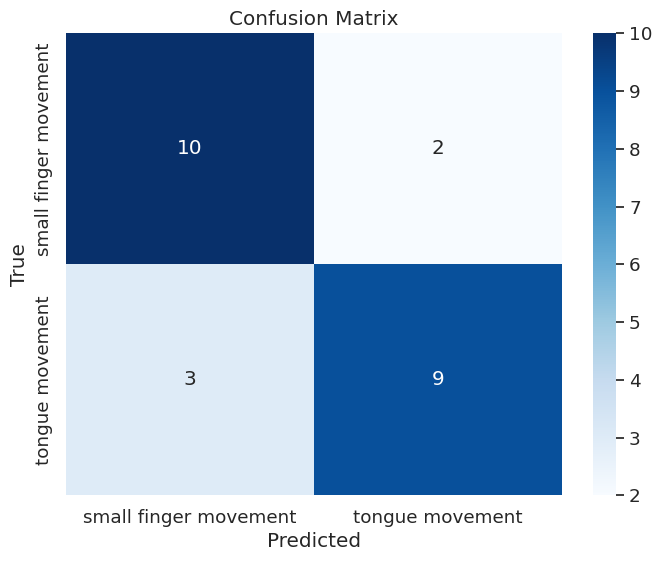

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels_max, predictions)

def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_labels = ['small finger movement', 'tongue movement']

plot_confusion_matrix(cm, labels=class_labels)

## Plot the loss and accuracy over epochs along with the training time:

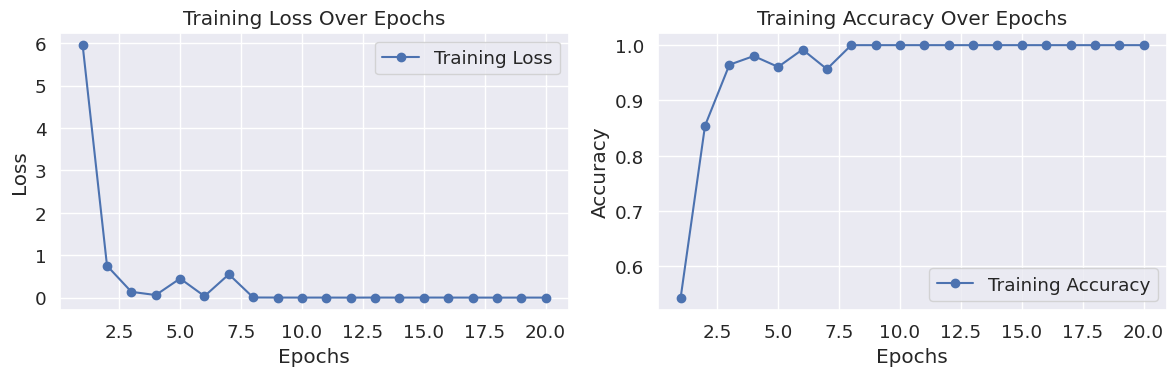

In [ ]:
# Create an array of epoch numbers
epochs = np.arange(1, num_epochs + 1)

# Plot loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], label='Training Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()



# Display the plots
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 28ms/step


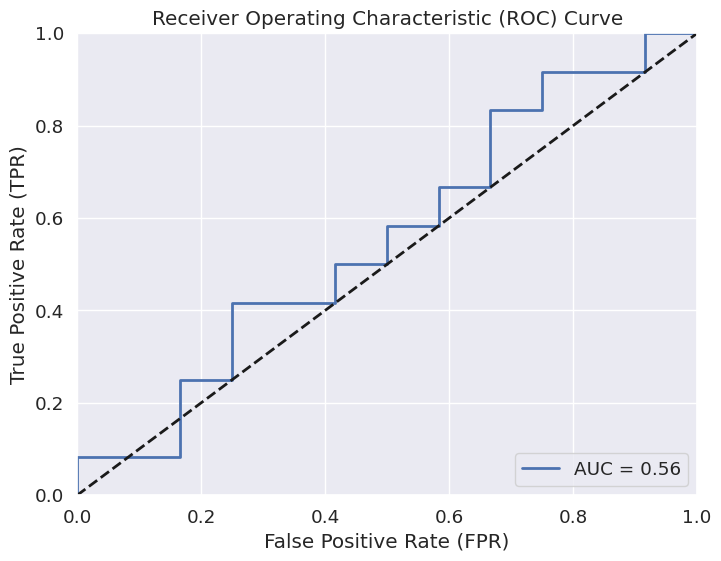

AUC Score: 0.56


In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Make predictions on the test data
y_pred_prob = model_basic.predict(X_val)
y_pred_prob_positive = y_pred_prob[:, 1]  # Probability of class 1 (positive class)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(true_labels_max, y_pred_prob_positive)

# Calculate the AUC score
auc = roc_auc_score(true_labels_max, y_pred_prob_positive)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print(f'AUC Score: {auc:.2f}')